<a href="https://colab.research.google.com/github/0jipy/192kbps_colab_JIPY/blob/main/911_%EB%89%B4%EC%8A%A4%EA%B7%B8%EB%A3%B9%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이콘 뉴스토픽분류 경진대회 자료이용했습니다. 

# 뉴스그룹분류 

    - Train / Test 데이터로 분류 되어있으며, 
    뉴스의 카테고리에 해당하는 내용이 topic dict 자료에 들어있습니다

- 파일 불러오기 / 경로설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
import os
os.chdir('/content/drive/MyDrive/뉴스 토픽 분류 AI 경진대회')

In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [116]:
train      = pd.read_csv("open/train_data.csv")
test       = pd.read_csv("open/test_data.csv")
# submission = pd.read_csv("open/sample_submission.csv")
topic_dict = pd.read_csv("open/topic_dict.csv")

## 데이터 탐색 및 트레인/테스트 셋 준비

- Train

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [76]:
train.head(3)

,index,title,topic_idx
0,0,인천핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4


In [77]:
train.shape

(45654, 3)

In [78]:
train.title = train.title.str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '') # 한글만 남기고 제거하기
train.title.values

array(['인천핀란드 항공기 결항휴가철 여행객 분통', '실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화',
       '이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것', ..., '게시판 키움증권  키움 영웅전 실전투자대회',
       '답변하는 배기동 국립중앙박물관장', ' 한국인터넷기자상 시상식 내달 일 개최특별상 김성후'], dtype=object)

- Test

In [79]:
test.isnull().sum() # topic_idx (뉴스그룹번호) 없는것, 비지도학습 체크체크

index    0
title    0
dtype: int64

In [80]:
test.head(3)

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다


In [81]:
test.title = test.title.str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '') # 한글만 남기고 제거하기
test.title.values

array(['유튜브 내달 일까지 크리에이터 지원 공간 운영', '어버이날 맑다가 흐려져남부지방 옅은 황사',
       '내년부터 국가 평가 때 논문건수는 반영 않는다', ..., '년 전 부마항쟁 부산 시위 사진 점 최초 공개',
       '게시판 아리랑 아프리카개발은행 총회 개회식 생중계', '유영민 과기장관 강소특구는 지역 혁신의 중심지원책 강구'],
      dtype=object)

In [82]:
X_train = train.title.values
y_train = train.topic_idx.values
X_train.shape, y_train.shape

((45654,), (45654,))

In [84]:
X_test = test.title.values
X_test.shape
# 비지도 학습 뉴스카테고리 값인 y_test. 없어. 어떻게 평가를 할 수 있을지? 밸리데이션으로 모델평가?
# - ? 실제 데이터 20개 평가해봐야 하나 ?

(9131,)

In [85]:
type(X_train), type(y_train), type(X_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

## 피쳐 벡터화 케라스의 토크나이저 이용

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [88]:
tok = Tokenizer()
tok.fit_on_texts(X_train)

In [89]:
threshold = 2
total_cnt = len(tok.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [92]:
print(tok.word_counts)

OrderedDict([('인천핀란드', 1), ('항공기', 18), ('결항휴가철', 1), ('여행객', 13), ('분통', 4), ('실리콘밸리', 7), ('넘어서겠다구글', 1), ('조원', 142), ('들여', 5), ('전역', 31), ('거점화', 1), ('이란', 533), ('외무', 60), ('긴장완화', 4), ('해결책은', 1), ('미국이', 10), ('경제전쟁', 3), ('멈추는', 2), ('것', 495), ('클린턴', 13), ('측근기업', 1), ('특수관계', 1), ('조명공과', 1), ('사', 40), ('맞물려종합', 1), ('시진핑', 79), ('트럼프에', 22), ('중미', 9), ('무역협상', 32), ('조속', 7), ('타결', 12), ('희망', 39), ('팔레스타인', 29), ('가자지구서', 4), ('세', 131), ('소년', 12), ('이스라엘군', 10), ('총격에', 3), ('사망', 224), ('인도', 75), ('년', 838), ('만에', 435), ('파키스탄', 23), ('공습테러', 1), ('캠프', 20), ('폭격종합보', 1), ('대선', 117), ('토론', 23), ('음담패설', 4), ('만회실패', 1), ('트럼프사과', 1), ('대신', 67), ('빌클린턴', 1), ('공격해', 3), ('역효과', 2), ('푸틴', 52), ('한반도', 78), ('상황', 41), ('진전', 20), ('위한', 187), ('방안', 43), ('김정은', 309), ('위원장과', 9), ('논의', 184), ('특검', 47), ('면죄부', 4), ('받은', 30), ('트럼프', 460), ('스캔들', 15), ('보도', 61), ('언론', 101), ('맹공국민의', 1), ('적', 20), ('오키나와서', 2), ('열린', 38), ('강제징용', 6), ('노동자', 59), ('추

In [93]:
for key, value in tok.word_counts.items():  # 딕셔너리라서 items()
    total_freq += value
    if value < threshold:   # 단어의 등장 빈도가 threshold보다 작을 경우
        rare_cnt += 1
        rare_freq += value

In [94]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print(f'등장 빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 89535
등장 빈도가 1번 이하인 희귀 단어의 수: 64241
단어 집합에서 희귀 단어의 비율: 71.74959513039593
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 22.334907136350676


In [95]:
vocab_size = total_cnt-rare_cnt + 2
vocab_size

25296

In [98]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) 

In [99]:
print('제목의 평균길이 :',sum(map(len, X_train))/len(X_train))
print('제목의 최대 길이 :',max(len(title) for title in X_train))

제목의 평균길이 : 6.300127042537346
제목의 최대 길이 : 12


In [101]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## GRU로 카테고리컬 분류 

In [103]:
model_GRU = Sequential([
        Embedding(vocab_size, 32, input_length=max_len),
        GRU(64),
        Dense(7, activation='softmax')
])
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 32)             809472    
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 828,743
Trainable params: 828,743
Non-trainable params: 0
_________________________________________________________________


In [104]:
# 컴파일
model_GRU.compile(loss='sparse_categorical_crossentropy',    # 스파스, 확률값 아닌 정수형태 클래스 
              optimizer='adam',
              metrics=['accuracy'])
model_path = 'newsgroup-gru.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [105]:
hist = model_GRU.fit(X_train, y_train, 
                 validation_split=0.2, epochs=10, verbose=1,
                 callbacks=[mc,es]
)

Epoch 1/10
1137/1142 [============================>.] - ETA: 0s - loss: 1.0342 - accuracy: 0.6267
Epoch 00001: val_loss improved from inf to 1.12796, saving model to newsgroup-gru.h5
1142/1142 [==============================] - 7s 5ms/step - loss: 1.0328 - accuracy: 0.6272 - val_loss: 1.1280 - val_accuracy: 0.5906
Epoch 2/10
1136/1142 [============================>.] - ETA: 0s - loss: 0.4677 - accuracy: 0.8472
Epoch 00002: val_loss improved from 1.12796 to 1.07126, saving model to newsgroup-gru.h5
1142/1142 [==============================] - 5s 4ms/step - loss: 0.4681 - accuracy: 0.8470 - val_loss: 1.0713 - val_accuracy: 0.6264
Epoch 3/10
1140/1142 [============================>.] - ETA: 0s - loss: 0.2781 - accuracy: 0.9082
Epoch 00003: val_loss did not improve from 1.07126
1142/1142 [==============================] - 5s 4ms/step - loss: 0.2780 - accuracy: 0.9082 - val_loss: 1.1642 - val_accuracy: 0.6309
Epoch 4/10
1135/1142 [============================>.] - ETA: 0s - loss: 0.1840 - a

In [109]:
# predict values
pred_gru = model_GRU.predict(X_test)
pred_gru

array([[3.1455152e-03, 4.1081294e-04, 5.6376517e-01, ..., 1.4901002e-06,
        1.0726338e-05, 7.3197721e-06],
       [6.8540203e-06, 1.4387896e-06, 2.6340002e-05, ..., 7.2524613e-09,
        4.3352152e-06, 1.6678509e-06],
       [1.3575057e-06, 1.8396499e-04, 5.5297371e-04, ..., 1.1070485e-05,
        5.9755857e-05, 9.9918228e-01],
       ...,
       [2.7604309e-01, 2.1805629e-04, 1.7745571e-03, ..., 7.1779150e-01,
        2.1399201e-03, 2.1774269e-06],
       [9.8313589e-04, 3.6363384e-05, 9.8799288e-01, ..., 8.7098965e-07,
        5.1079619e-06, 5.1474507e-04],
       [6.5648751e-03, 2.0460723e-02, 9.5416862e-01, ..., 1.5107178e-03,
        1.9795565e-04, 1.5329146e-02]], dtype=float32)

In [119]:
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [120]:
# X_test[3]
print(test.title[0]), print(pred_gru[0])
# 56퍼센트 사회, 43퍼센트 생활문화.

유튜브 내달 2일까지 크리에이터 지원 공간 운영
[3.1455152e-03 4.1081294e-04 5.6376517e-01 4.3265897e-01 1.4901002e-06
 1.0726338e-05 7.3197721e-06]


(None, None)

In [121]:
print(test.title[1]), print(pred_gru[1])
# 생활문화지 않을까 싶은데. 99퍼확률로 생활문화란다.

어버이날 맑다가 흐려져…남부지방 옅은 황사
[6.8540203e-06 1.4387896e-06 2.6340002e-05 9.9995935e-01 7.2524613e-09
 4.3352152e-06 1.6678509e-06]


(None, None)

- GRU 모델 시각화

In [122]:
import matplotlib.pyplot as plt

In [123]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1,len(y_acc)+1)

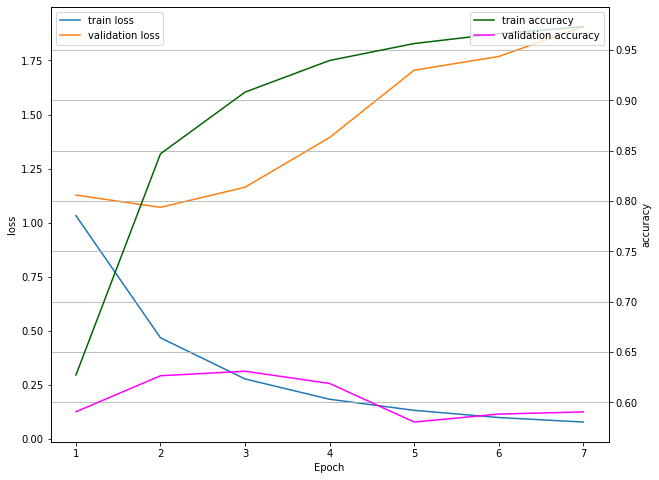

In [124]:
_, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, label='train loss')
ax0.plot(xs, y_vloss, label='validation loss')
ax0.set_ylabel('loss')
ax1.plot(xs, y_acc, c='darkgreen', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta', label='validation accuracy')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('Epoch')
ax0.legend()
ax1.legend(loc=1)
plt.grid()
plt.show()

## LSTM 카테고리컬 분류 
    - 학습 5회로

In [125]:
model_LSTM = Sequential([
        Embedding(vocab_size, 32, input_length=max_len),
        LSTM(64),
        Dense(7, activation='softmax')
])
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 8, 32)             809472    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 834,759
Trainable params: 834,759
Non-trainable params: 0
_________________________________________________________________


In [127]:
# 컴파일
model_LSTM.compile(loss='sparse_categorical_crossentropy',    # 스파스, 확률값 아닌 정수형태 클래스 
              optimizer='adam',
              metrics=['accuracy'])
model_path = 'newsgroup-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [128]:
# 학습 5회로 조정
hist = model_LSTM.fit(X_train, y_train, 
                 validation_split=0.2, epochs=5, verbose=1,
                 callbacks=[mc,es]
)

Epoch 1/5
1132/1142 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.6265
Epoch 00001: val_loss improved from inf to 1.13375, saving model to newsgroup-lstm.h5
1142/1142 [==============================] - 7s 5ms/step - loss: 1.0185 - accuracy: 0.6274 - val_loss: 1.1337 - val_accuracy: 0.5731
Epoch 2/5
1137/1142 [============================>.] - ETA: 0s - loss: 0.4850 - accuracy: 0.8372
Epoch 00002: val_loss improved from 1.13375 to 1.07394, saving model to newsgroup-lstm.h5
1142/1142 [==============================] - 5s 5ms/step - loss: 0.4851 - accuracy: 0.8373 - val_loss: 1.0739 - val_accuracy: 0.6083
Epoch 3/5
1140/1142 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.9060
Epoch 00003: val_loss did not improve from 1.07394
1142/1142 [==============================] - 5s 5ms/step - loss: 0.2889 - accuracy: 0.9060 - val_loss: 1.2406 - val_accuracy: 0.6045
Epoch 4/5
1141/1142 [============================>.] - ETA: 0s - loss: 0.1910 - acc

In [130]:
# predict values
pred_lstm = model_LSTM.predict(X_test)
# pred_lstm

In [ ]:
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [131]:
# X_test[3]
print(test.title[0]), print(pred_lstm[0])
# gru : 56퍼센트 사회, 43퍼센트 생활문화. 
# lstm : 92퍼 사회로 예측

유튜브 내달 2일까지 크리에이터 지원 공간 운영
[1.0166988e-02 3.0769760e-04 9.2305422e-01 6.6264667e-02 5.1519037e-06
 2.3779490e-05 1.7750167e-04]


(None, None)

In [133]:
print(test.title[1]), print(pred_lstm[1])
# gru : 생활문화지 않을까 싶은데. 99퍼확률로 생활문화란다.
# lstm : 99.9퍼센트 생활문화. 위 같은 결과. 날씨는 사회인가 생활문화 인가.

어버이날 맑다가 흐려져…남부지방 옅은 황사
[4.6084533e-05 4.0951316e-05 1.9239687e-04 9.9949646e-01 8.3390307e-07
 2.1570147e-04 7.5317939e-06]


(None, None)

## Simply RNN 카테고리컬 분류

In [135]:
from tensorflow.keras.layers import GlobalMaxPool1D

In [138]:
model_sRNN = Sequential([
        Embedding(vocab_size, 32, input_length=max_len),
        GlobalMaxPool1D(),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')               
])
model_sRNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 8, 32)             809472    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 7)                 231       
                                                                 
Total params: 810,759
Trainable params: 810,759
Non-trainable params: 0
_________________________________________________________________


In [139]:
# 컴파일
model_sRNN.compile(loss='sparse_categorical_crossentropy',    # 스파스, 확률값 아닌 정수형태 클래스 
              optimizer='adam',
              metrics=['accuracy'])
model_path = 'newsgroup-sRNN.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [140]:
hist = model_sRNN.fit(X_train, y_train, 
                 validation_split=0.2, epochs=5, verbose=1,
                 callbacks=[mc,es]
)

Epoch 1/5
1133/1142 [============================>.] - ETA: 0s - loss: 1.2444 - accuracy: 0.5786
Epoch 00001: val_loss improved from inf to 1.15884, saving model to newsgroup-sRNN.h5
1142/1142 [==============================] - 5s 4ms/step - loss: 1.2421 - accuracy: 0.5796 - val_loss: 1.1588 - val_accuracy: 0.6011
Epoch 2/5
1134/1142 [============================>.] - ETA: 0s - loss: 0.5171 - accuracy: 0.8412
Epoch 00002: val_loss improved from 1.15884 to 1.06229, saving model to newsgroup-sRNN.h5
1142/1142 [==============================] - 6s 5ms/step - loss: 0.5173 - accuracy: 0.8411 - val_loss: 1.0623 - val_accuracy: 0.6313
Epoch 3/5
1139/1142 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9223
Epoch 00003: val_loss did not improve from 1.06229
1142/1142 [==============================] - 7s 6ms/step - loss: 0.2567 - accuracy: 0.9224 - val_loss: 1.1090 - val_accuracy: 0.6361
Epoch 4/5
1141/1142 [============================>.] - ETA: 0s - loss: 0.1297 - acc

In [141]:
# predict values
pred_srnn = model_sRNN.predict(X_test)

In [144]:
topic_dict.topic

0    IT과학
1      경제
2      사회
3    생활문화
4      세계
5     스포츠
6      정치
Name: topic, dtype: object

In [143]:
print(test.title[0]), print(pred_srnn[0])
# gru : 56퍼센트 사회, 43퍼센트 생활문화. 
# lstm : 92퍼 사회로 예측
# srnn : 55퍼센트 사회, 20퍼센트 생활문화. 23퍼센트 경제로 분류되는게 신기합니다. 경제는 아닌것 같아요.

유튜브 내달 2일까지 크리에이터 지원 공간 운영
[1.4152455e-02 2.3373254e-01 5.5021381e-01 2.0153406e-01 1.5888290e-04
 5.5690765e-05 1.5257501e-04]


(None, None)

In [145]:
print(test.title[1]), print(pred_srnn[1])
# gru : 생활문화지 않을까 싶은데. 99퍼확률로 생활문화란다.
# lstm : 99.9퍼센트 생활문화. 위 같은 결과. 날씨는 사회인가 생활문화 인가.
# srnn : 99.9퍼센트 생활문화 입니다.

어버이날 맑다가 흐려져…남부지방 옅은 황사
[1.2248939e-04 2.2563958e-05 2.2899245e-04 9.9953198e-01 1.4965757e-05
 7.9013997e-05 8.5110877e-08]


(None, None)